In [89]:
import matplotlib.pyplot as plt
import math
from scipy.linalg import hadamard
from sklearn import linear_model

# Everything in the below chunk is copied from the new RLA.py

In [74]:
import numpy as np
from numpy import *
from numpy import linalg as LA
import pandas as pd
import types
import random

def RLA_mult(A, B, c, distribution = "uniform"):
	"""
	This function takes two large matrices A and B,
	and computes A*B through random linear algebra method.

	input:
	A: m * n matrix (it can be numpy array or 2D python list)
	B: n * p matrix (it can be numpy array or 2D python list)
	c: positive integer, the number of samples
	distribution: takes two values ["uniform", "minvar"]
				  "minvar" is a probability distribution minimizes variance.
	----------------
	output: approximation for AB
	"""

	# convert A and B to numpy arrays
	if type(A) is list:
		A = np.array(A)
	if type(B) is list:
		B = np.array(B)


	m = A.shape[0]    # A: m*n; B:n*p
	n = A.shape[1]
	p = B.shape[1]
	# check if dimensions of two matrices match
	if n != B.shape[0]:
		print("Dimensions of two matrices don't match.")
		return


	# if the selected sampling distribution is uniform
	if distribution == "uniform":
		answer = np.zeros((m, p))
		for t in range(c):
			i = random.randint(0, n-1)
			A_icol = A[:, [i]]
			B_irow = B[[i], :]
			answer += np.matmul(A_icol, B_irow)
		return n * answer / c


	# if the selected sampling distribution is to minimize variance
	elif distribution == "minvar":
		# calculate the sample distribution
		weight_sum = 0
		weights = []
		for i in range(n):
			w = np.linalg.norm(A[:, i]) * np.linalg.norm(B[i, :])
			weights.append(w)
			weight_sum += w
		weights = np.array(weights) / weight_sum

		# sample and calculate the answer
		answer = np.zeros((m, p))
		for t in range(c):
			i = np.random.choice(np.arange(0, n), p = weights)
			A_icol = A[:, [i]]
			B_irow = B[[i], :]
			answer += np.matmul(A_icol, B_irow) * (1/weights[i])
		return answer / c

	else:
		print("Probability distribution type not valid.")





def generate_matrix(m, n, method=1, param = [0,1]):
	"""
	This function takes in dimensions m and n,
	to randomly generate a matrix of m*n.
	Each element in the matrix is drawn according to the method and param specified.

	input:
	m: int; the number of rows
	n: int; the number of columns
	method: int; represent the method/distirbution we generate matrix from
	        method = 1: all elements drawn from Uniform(param[0], param[1]).
	        method = 2: all elements drawn from Normal(param[0], param[1]^2)
			method = 3: all elements are binary, take either 0 (probability of param[0]) or 1 (probability of param[1]),
						where param[0]+param[1] = 1.
	----------------
	output: a 2-D numpy array representing the randomly generated matrix according to method and param.
	"""
	# uniform distribution
	if method == 1:
		M = np.random.rand(m,n)
		if len(param) != 2:
			return M
		M = M * (param[1]-param[0])
		M = M + param[0]
		return M

	# normal distribution
	if method == 2:
		if len(param) != 2:
			return np.random.normal(0, 1, size=(m, n))
		else:
			return np.random.normal(param[0], param[1], size=(m, n))

	# bernoumlli distribution
	if method == 3:
		M = np.zeros((m,n))
		for i in range(m):
			for j in range(n):
				elem = np.random.choice(np.arange(0, 2), p = param)
				M[i,j] = elem
		return M

	else:
		print("Specified method not recognized.")






def frobenius_dist(true_mat, approx_mat):
	"""
	This function computes the frobenius distance between the approximated matrix
	and the true matrix.
	Which is given by the frobenius norm of (true_mat-approx_mat)/

	input:
	true_mat: numpy 2-D array; the true matrix
	approx_mat: numpy 2-D array; the approximated matrix
	----------------
	output: double; the frobenius distance between true_mat and approx_mat
	"""
	if true_mat.shape[0] == approx_mat.shape[0] and true_mat.shape[1] == approx_mat.shape[1]:
		diff = true_mat - approx_mat
		return LA.norm(diff, 'fro')
	else:
		print("Dimensions of two matricies doesn't match.")

In [75]:
# test above code
a = np.array([[1, 2, 0],
	          [3, 4, 2]])
b = np.array([[3, 4, 5],
	          [5, 6, 8]])
print(frobenius_dist(a,b))

# print("Normal matrix multiplication:")
# print(np.matmul(a, b))
# print("Minimize variance RLA multiplication:")
# print(RLA_mult(a, b, 20, "minvar"))
# print("Uniform distirbution RLA multiplication:")
# print(RLA_mult(a, b, 20))


8.774964387392123


In [108]:
def traditional_mult(A, B):
    """
    This function takes two large matrices A and B,
    and computes A*B through traditional multiplication method. 

    input:
    A: m * n matrix (it can be numpy array or 2D python list)
    B: n * p matrix (it can be numpy array or 2D python list)
    ----------------
    output: AB
    """

    # convert A and B to numpy arrays
    if type(A) is list:
        A = np.array(A)
    if type(B) is list:
        B = np.array(B)
        
    m = A.shape[0]    # A: m*n; B:n*p
    n = A.shape[1]
    p = B.shape[1]
    # check if dimensions of two matrices match
    if n != B.shape[0]:
        print("Dimensions of two matrices don't match.")
        return
    
    AB = np.zeros((m,p))
    
    for i in range(m):
        for j in range(p):
            AB[i,j] = np.matmul(A[i,:],B[:,j])
    
    return AB

In [90]:
# test above code 
a = np.array([[1, 2],
              [3, 4]])
b = np.array([[3, 4],
              [5, 6]])

print(traditional_mult(a,b))
print(traditional_mult(b,a))

[[13. 16.]
 [29. 36.]]
[[15. 22.]
 [23. 34.]]


In [ ]:
def RLasso_sampling(A, b, err_tolerance, alpha=0.1):
    """
    A is a n*d matrix, b is a n-element vector.
    We aim to use random sampling to construct a reduced version of the problem,
    and solve through LASSO regression.
    
    input: 
    A: numpy 2D array of n*d representing data points where n is the number of data points
    b: n-element vector
    alpha: hyperparameter representing the coefficient in front of LASSO regularizing factor
    err_tolerance: error tolerance for the randomized regression
    ---------------------------------
    output: a model object that contains approximated solution x for Ax=b using LASSO regression
    """
    n = A.shape[0]
    d = A.shape[1]

    # compute the proper r
    ln40nd = np.log(40*n*d)
    r = max(48*48*d*ln40nd*np.log(10000*d*ln40nd), 40*d*ln40nd/err_tolerance)
    r = int(r)
    print("Computed r is", r)
    
    # construct S matrix
    S = np.zeros((n,r))
    for l in range(r):
        k_l = random.randint(0, n-1)
        S[k_l, l] = math.sqrt(n/r)
    
    # construct H, note that H is n*n where n is a power of 2
    H = hadamard(n)/sqrt(n)
    
    # construct D, note that D is n*n diagonal matrix
    D = np.identity(n)
    for i in range(n):
        if random.random() < 0.5:
            D[i,i] = -1
    
    P = np.matmul(np.matmul(np.transpose(S), H), D)
    newA = np.matmul(P, A)
    newb = np.matmul(P, b)
    
    # solve the lasso regression problem
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(newA, newb)
    
    # returns a model object.
    # use clf.intercept_ to get the intercept
    # use clf.coef_ to get the coefficients
    return clf

In [ ]:
# test above code 
a = np.array([[1, 2],
              [3, 4]])
b = np.array([[3],
              [5]])

model = RLasso_sampling(a, b, 0.1, alpha=0.1)
print(model.intercept_)
print(model.coef_)

In [137]:
def RLasso_projection(A, b, err_tolerance, Cq, Ck, alpha=0.1):
    """
    A is a n*d matrix, b is a n-element vector.
    We aim to use random sampling to construct a reduced version of the problem,
    and solve through LASSO regression.
    
    input: 
    A: numpy 2D array of n*d representing data points where n is the number of data points
    b: n-element vector
    alpha: hyperparameter representing the coefficient in front of LASSO regularizing factor
    err_tolerance: error tolerance for the randomized regression
    Cq: tunable hyperparameters according to the random projection algorithm
    Ck: tunable hyperparameters according to the random projection algorithm
    ---------------------------------
    output: a model object that contains approximated solution x for Ax=b using LASSO regression
    """
    n = A.shape[0]
    d = A.shape[1]

    # compute the proper r
    ln40nd = np.log(40*n*d)
    q = Cq*d*ln40nd/n*(2*np.log(n)+16*d+16)
    print(q)
    r = int(max(Ck*(188*188*d+98*98), 60*d/err_tolerance))
    
    # construct T matrix
    T = np.zeros((r,n))
    for i in range(r):
        for j in range(n):
            possible_entries = [sqrt(1/r/q), -sqrt(1/r/q), 0]
            weights = [q/2, q/2, 1-q]
            T[i,j] = np.random.choice(possible_entries, p = weights)
    
    # construct H, note that H is n*n where n is a 
    H = hadamard(n)/sqrt(n)
    
    # construct D, note that D is n*n diagonal matrix
    D = np.identity(n)
    for i in range(n):
        if random.random() < 0.5:
            D[i,i] = -1
    
    P = np.matmul(np.matmul(T, H), D)
    newA = np.matmul(P, A)
    newb = np.matmul(P, b)
    
    # solve the lasso regression problem
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(newA, newb)
    
    # returns a model object.
    # use clf.intercept_ to get the intercept
    # use clf.coef_ to get the coefficients
    return clf

In [146]:
# test above code 
a = np.array([[1, 2],
              [3, 4],
              [3, 4],
              [9, 10],
              [3, 2],
              [1, 1],
              [2, 6],
              [7, 4]])
b = np.array([[3],
              [5],
              [7],
              [0],
              [2],
              [1],
              [0],
              [2]])

model = RLasso_projection(a, b, 2, 0.0009, 0.00008, alpha=0.1)
print(model.intercept_)
print(model.coef_)

0.07583016671038863
[0.09033794]
[-0.          0.48190263]


# Test the accuracy of randomized matrix multiplication using for matricies with different size

Currently at n = 50
Currently at n = 100
Currently at n = 150
Currently at n = 200
Currently at n = 250


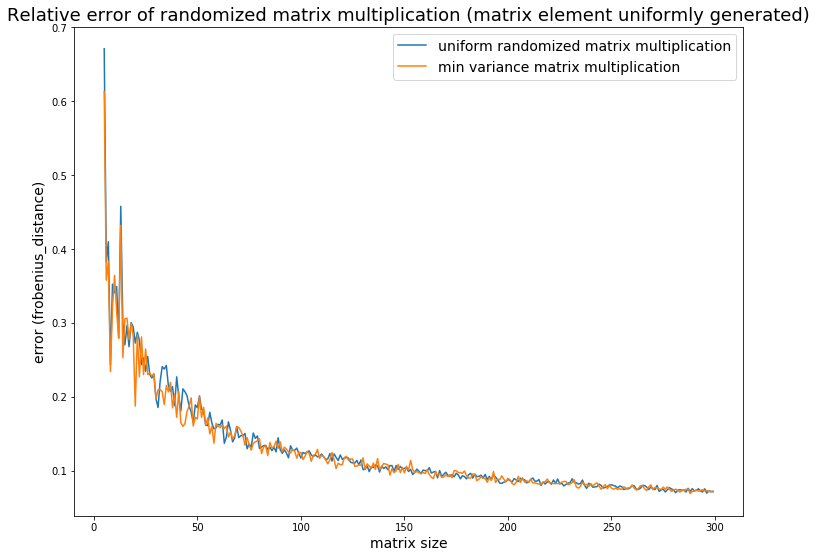

In [45]:
forb_dist_uniform = []
forb_dist_minvar = []
method = 1
param = [0,5]
c_proportion = 0.5
repetition = 3

np.random.seed(1)

"""
For n from 5 to 300, generate n*n matricies A and B. 
Look at the error of approximating AB using our two RLA sampling method.
RLA sampling size is defined by c_proportion. 
Currently the sampling size is half of n. 
"""

for n in range(5, 300):
    uniform_dist = 0
    minvar_dist = 0
    if n % 50 == 0:
        print("Currently at n =",n)
    
    # randomly generate the matrix
    A = generate_matrix(n, n, method=method, param=param)
    B = generate_matrix(n, n, method=method, param=param)
    
    # calculate the true AB
    AB = np.matmul(A,B)
    AB_fro_norm = LA.norm(AB, 'fro')
    
    # calculate the approximation of AB using different sampling distributions
    # sample size is c = c_proportion * n
    c = max(1, int(c_proportion * n))
    
    for i in range(repetition):
        AB_rla_uniform = RLA_mult(A, B, c, distribution = "uniform")
        AB_rla_minvar = RLA_mult(A, B, c, distribution = "minvar")
        
        # calculate the frobenius distance between approx and true to evaluate performance
        uniform_dist += frobenius_dist(AB, AB_rla_uniform)/AB_fro_norm
        minvar_dist += frobenius_dist(AB, AB_rla_minvar)/AB_fro_norm
        
    uniform_dist /= repetition
    minvar_dist /= repetition
    
    forb_dist_uniform.append(uniform_dist)
    forb_dist_minvar.append(minvar_dist)
    

plt.figure(figsize=(12,9))
plt.plot(np.arange(5,300), forb_dist_uniform, label = "uniform randomized matrix multiplication") # plot the potential function
plt.plot(np.arange(5,300), forb_dist_minvar, label = "min variance matrix multiplication")
    
    
plt.title("Relative error of randomized matrix multiplication (matrix element uniformly generated)", fontsize=18)
plt.xlabel('matrix size', fontsize=14)
plt.ylabel('error (frobenius_distance)', fontsize=14)
plt.legend(fontsize=14)

Currently at n = 50
Currently at n = 100
Currently at n = 150
Currently at n = 200
Currently at n = 250
Currently at n = 300
Now generating the plot...


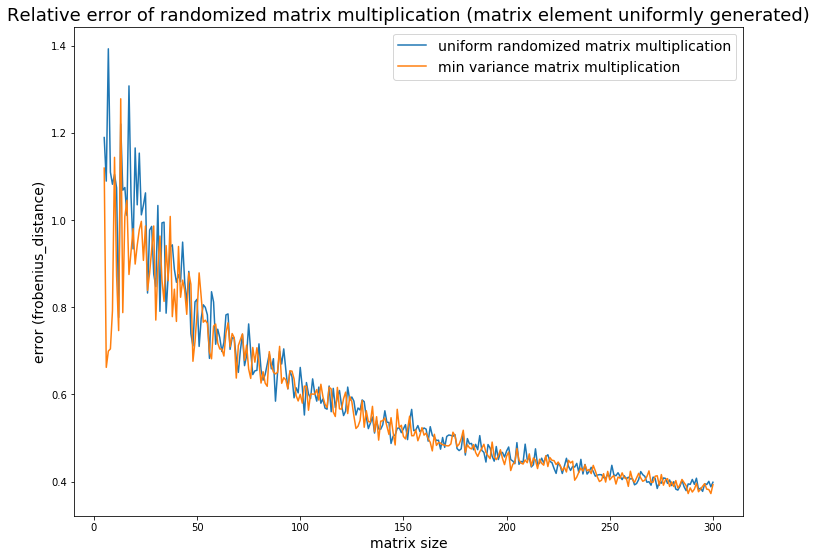

In [46]:
forb_dist_uniform = []
forb_dist_minvar = []
method = 3
param = [0.8, 0.2]
c_proportion = 0.5


np.random.seed(1)

"""
For n from 5 to 300, generate n*n matricies A and B. 
Look at the error of approximating AB using our two RLA sampling method.
RLA sampling size is defined by c_proportion. 
Currently the sampling size is half of n. 
"""

for n in range(5, 301):
    uniform_dist = 0
    minvar_dist = 0
    if n % 50 == 0:
        print("Currently at n =",n)
    
    # randomly generate the matrix
    A = generate_matrix(n, n, method=method, param=param)
    B = generate_matrix(n, n, method=method, param=param)
    
    # calculate the true AB
    AB = np.matmul(A,B)
    AB_fro_norm = LA.norm(AB, 'fro')
    
    # calculate the approximation of AB using different sampling distributions
    # sample size is c = c_proportion * n
    c = max(1, int(c_proportion * n))
    
    for i in range(repetition):
        AB_rla_uniform = RLA_mult(A, B, c, distribution = "uniform")
        AB_rla_minvar = RLA_mult(A, B, c, distribution = "minvar")
        
        # calculate the frobenius distance between approx and true to evaluate performance
        uniform_dist += frobenius_dist(AB, AB_rla_uniform)/AB_fro_norm
        minvar_dist += frobenius_dist(AB, AB_rla_minvar)/AB_fro_norm
        
    uniform_dist /= repetition
    minvar_dist /= repetition
    
    forb_dist_uniform.append(uniform_dist)
    forb_dist_minvar.append(minvar_dist)
    
print("Now generating the plot...")
plt.figure(figsize=(12,9))
plt.plot(np.arange(5,301), forb_dist_uniform, label = "uniform randomized matrix multiplication") # plot the potential function
plt.plot(np.arange(5,301), forb_dist_minvar, label = "min variance matrix multiplication")
    
    
plt.title("Relative error of randomized matrix multiplication (matrix element uniformly generated)", fontsize=18)
plt.xlabel('matrix size', fontsize=14)
plt.ylabel('error (frobenius_distance)', fontsize=14)
plt.legend(fontsize=14)

# as sample size increase, what's the similarity between true AB and approximated AB

In [118]:
forb_norm_uniform = []
forb_norm_minvar = []
method = 3
param = [0.8, 0.2]


np.random.seed(1)

"""
A and B are both randomly generated matrices,
A has m*n elements and B has n*p elements.
We aim to find as sample size c increase,
how does the similarity between approximated multiplication and true multiplication change. 
"""

m = 400
n = 600
p = 380
A = generate_matrix(m, n, method=method, param=param)
B = generate_matrix(n, p, method=method, param=param)
AB = np.matmul(A,B)
AB_fro_norm = LA.norm(AB, 'fro')/m/p
x_axis = []
for c in range(10, int(n*1.5)):
    if c % 50 == 0:
        print("Currently at c =", c)
    if c % 2 == 0:
        continue
    x_axis.append(c)
    AB_rla_uniform = RLA_mult(A, B, c, distribution = "uniform")
    forb_norm_uniform.append(LA.norm(AB_rla_uniform, 'fro')/m/p)
    
    AB_rla_minvar = RLA_mult(A, B, c, distribution = "minvar")
    forb_norm_minvar.append(LA.norm(AB_rla_minvar, 'fro')/m/p)

Currently at c = 50
Currently at c = 100
Currently at c = 150
Currently at c = 200
Currently at c = 250
Currently at c = 300
Currently at c = 350
Currently at c = 400
Currently at c = 450
Currently at c = 500
Currently at c = 550
Currently at c = 600
Currently at c = 650
Currently at c = 700
Currently at c = 750
Currently at c = 800
Currently at c = 850


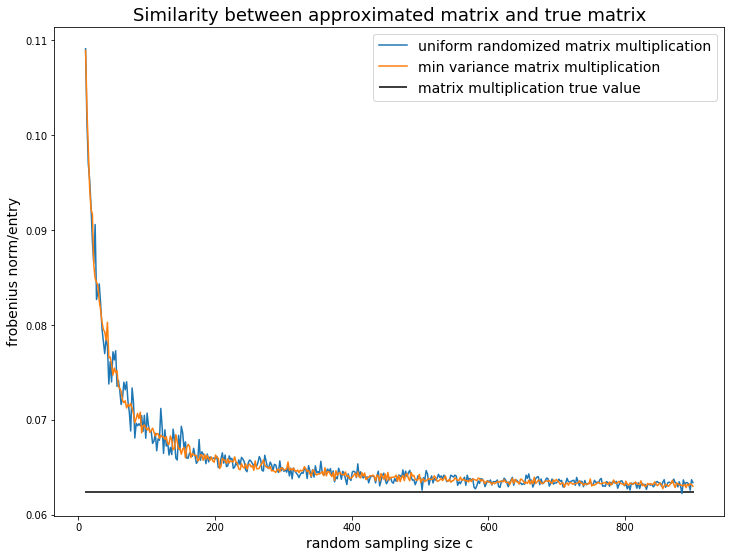

In [121]:
plt.figure(figsize=(12,9))
plt.hlines(AB_fro_norm, 10, int(n*1.5), label = "matrix multiplication true value")
plt.plot(x_axis, forb_norm_uniform, label = "uniform randomized matrix multiplication")
plt.plot(x_axis, forb_norm_minvar, label = "min variance matrix multiplication")
    
    
plt.title("Similarity between approximated matrix and true matrix", fontsize=18)
plt.xlabel('random sampling size c', fontsize=14)
plt.ylabel('frobenius norm/entry', fontsize=14)
plt.legend(fontsize=14)

From the above graph we can see that, indeed uniform sampling distribution does have higher variance than min variance mathod.
We can also see that as c increase, the approximated matrix using randomized method gets increasingly close to the true matrix value. 

# speed test

In [113]:
import time
traditional_time = []
uniform_time = []
minvar_time = []
method = 2
param = [50, 50]
c_proportion = 0.5
repetition = 2


np.random.seed(1)

"""
A and B are both randomly generated matrices,
we aim to find as matrix size increase,
how much time it takes to compute the multiplication in the traditional way,
versus using RLA.
"""


for n in range(100, 1000):
    if n % 100 == 0:
        print("Currently at n =", n)
    if n % 3 != 0:
        continue
    A = generate_matrix(n, n, method=method, param=param)
    B = generate_matrix(n, n, method=method, param=param)
    
    # estimate the time for traditional matrix multiplication
    start = time.time()
    for i in range(repetition):
        AB = traditional_mult(A, B)
    end = time.time()
    time_diff = end-start
    traditional_time.append(time_diff/repetition)

    # estimate the time for rla uniform
    start = time.time()
    for i in range(repetition):
         AB_rla_uniform = RLA_mult(A, B, c, distribution = "uniform")
    end = time.time()
    time_diff = end-start
    uniform_time.append(time_diff/repetition)
    
    
    # estimate the time for rla minvar
    start = time.time()
    for i in range(repetition):
         AB_rla_minvar = RLA_mult(A, B, c, distribution = "minvar")
    end = time.time()
    time_diff = end-start
    minvar_time.append(time_diff/repetition)

Currently at n = 100
Currently at n = 200
Currently at n = 300
Currently at n = 400
Currently at n = 500
Currently at n = 600
Currently at n = 700
Currently at n = 800
Currently at n = 900


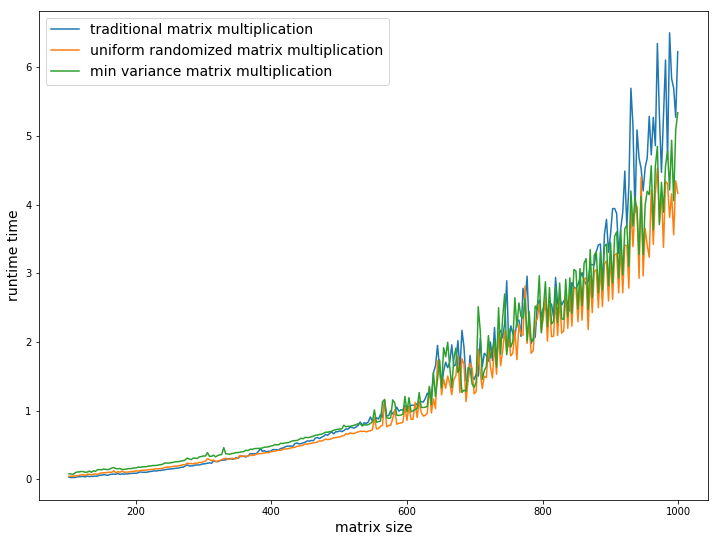

In [117]:
plt.figure(figsize=(12,9))
plt.plot([i*3 for i in range(34,334)], traditional_time, label = "traditional matrix multiplication")
plt.plot([i*3 for i in range(34,334)], uniform_time, label = "uniform randomized matrix multiplication")
plt.plot([i*3 for i in range(34,334)], minvar_time, label = "min variance matrix multiplication")
    
    
plt.title("", fontsize=18)
plt.xlabel('matrix size', fontsize=14)
plt.ylabel('runtime time', fontsize=14)
plt.legend(fontsize=14)